In [361]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst, u_arrays as ua
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
from utils import u_statistics as u_stat
from scipy.stats import norm
import matplotlib.mlab as mlab
import pickle as pkl
from scipy.optimize import curve_fit

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [886]:
h = 18
file = cnst.network_data + '/data/NFLICS/tables/prob_dictionary/Sahel_MCS10W10E_noOverlap_' + str(h).zfill(2) + '.p'
tag = 'Sahel'
# file = cnst.network_data + '/data/NFLICS/tables/prob_dictionary/Sahel_MCS_Senegal_' + str(h).zfill(2) + '.p'
# tag = 'Senegal'
dic = pkl.load( open(file, "rb"))

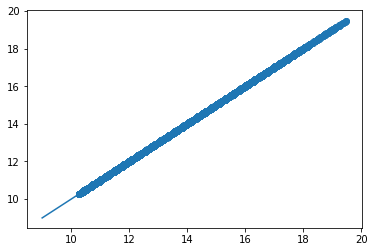

In [887]:
plt.scatter(dic['ccord'][1], dic['tcord'][1])
plt.plot(np.arange(9,19), np.arange(9,19))

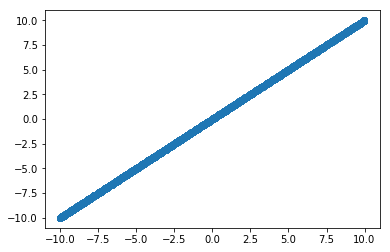

In [888]:
plt.scatter(dic['ccord'][0], dic['tcord'][0])
plt.plot(np.arange(-10,11), np.arange(-10,11))

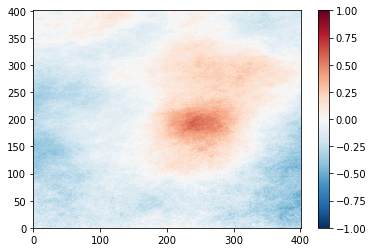

In [889]:
plt.pcolormesh((dic['akern'][0]).squeeze()/(dic['akern'][1]).squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

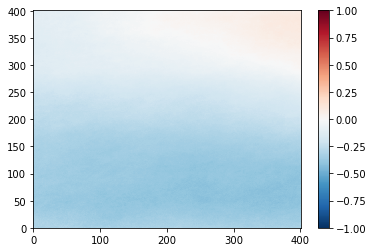

In [890]:
plt.pcolormesh((dic['rkern'][0]).squeeze()/(dic['rkern'][1]).squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

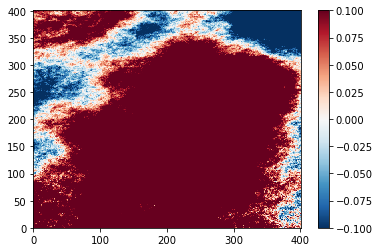

In [891]:
plt.pcolormesh((dic['akern'][0]).squeeze()/(dic['akern'][1]).squeeze()-(dic['rkern'][0]).squeeze()/(dic['rkern'][1]).squeeze(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
plt.colorbar()

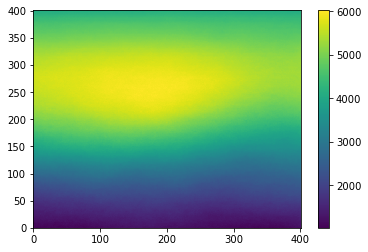

In [892]:
plt.pcolormesh((dic['akern'][1]).squeeze())
plt.colorbar()

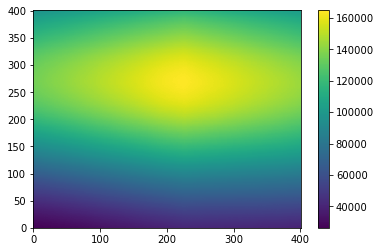

In [893]:
plt.pcolormesh((dic['rkern'][1]).squeeze())
plt.colorbar()

In [894]:
print(len(dic['ramsr'][1]))
print(len(dic['amsr'][1]))

199154
6963


In [895]:
cinput = np.array(dic['amsr'][1])
rinput = np.array(dic['ramsr'][1])
point = cinput[np.isfinite(cinput)]
all = rinput[np.isfinite(rinput)]

nbpoint, pointcount, bins = u_stat.histo_frequency(point, bins=np.arange(-15,15.1,1))
nball, allcount, bins = u_stat.histo_frequency(all, bins=np.arange(-15, 15.1, 1))
print(bins)
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
bin_edge = bins[0:-1]
width = bins[1::] - bins[0:-1]

[-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.]


In [896]:
nbpoint

array([1.57977883e-03, 1.29254632e-03, 1.00531380e-03, 1.43616257e-03,
       1.14893006e-03, 3.59040643e-03, 5.31380152e-03, 8.76059170e-03,
       9.04782421e-03, 1.79520322e-02, 3.24572742e-02, 5.06965388e-02,
       8.24357317e-02, 1.16041936e-01, 1.43329025e-01, 1.49791756e-01,
       1.25520609e-01, 8.94729283e-02, 5.80209680e-02, 4.40901910e-02,
       2.87232515e-02, 1.53669395e-02, 8.04251041e-03, 3.15955766e-03,
       5.74465029e-04, 1.43616257e-04, 1.43616257e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [897]:
# best fit of data
(mupoint, sigmapoint) = norm.fit(point)
(muall, sigmaall) = norm.fit(all)

# add a 'best fit' line
ypoint = mlab.normpdf( bin_centre, mupoint, sigmapoint)
yall = mlab.normpdf(bin_centre, muall, sigmaall)

# add a 'best fit' line
cypoint = norm.cdf( bin_centre, mupoint, sigmapoint)
cyall = norm.cdf(bin_centre, muall, sigmaall)

print('Core', norm.pdf(0,mupoint,sigmapoint))
print('Random', norm.pdf(0,muall,sigmaall))


Core 0.1252775981119411
Random 0.12215983452368023


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


In [898]:
np.sum(yall)

0.9999961627961121

In [899]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

In [900]:
poptpoint, _ = curve_fit(gaussian, bin_centre, nbpoint, p0=[1., 0., 1.])
poptall, _ = curve_fit(gaussian, bin_centre, nball, p0=[1., 0., 1.])

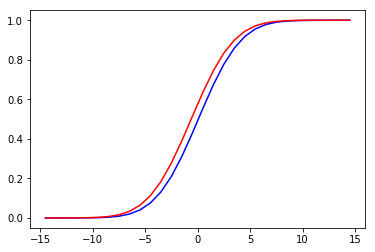

In [901]:
plt.plot(bin_centre,cypoint, 'b')
plt.plot(bin_centre, cyall, 'r')

58.55% of Cells occur in warmest half


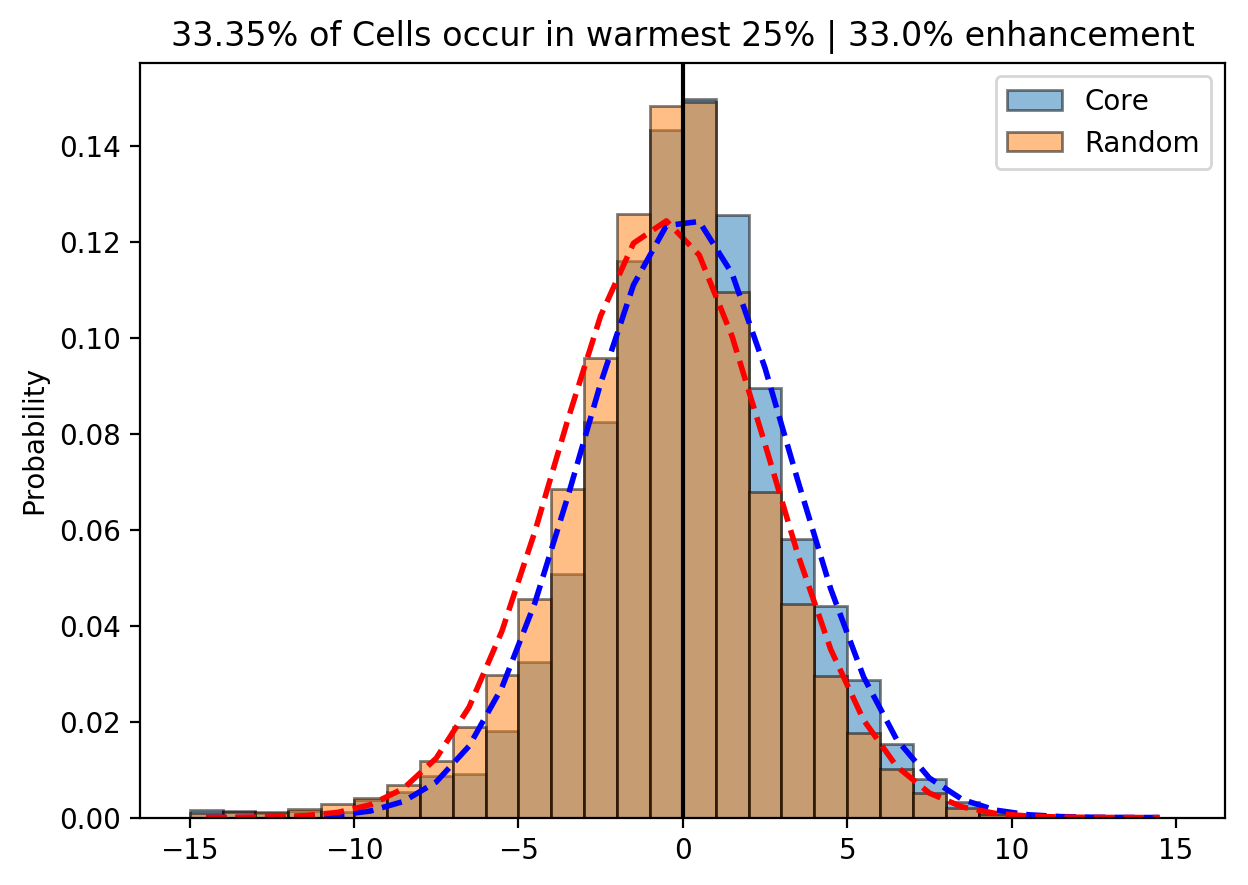

In [902]:
f = plt.figure(figsize=(7,5), dpi=200)
ax = f.add_subplot(111)

ax.bar(bin_edge, nbpoint, label='Core', edgecolor='k', alpha=0.5, align='edge', width=width)
ax.bar(bin_edge, nball, label='Random', edgecolor='k', alpha=0.5, align='edge', width=width)

plt.plot(bin_centre, ypoint/np.sum(ypoint), 'b--', linewidth=2)
plt.plot(bin_centre, yall/np.sum(yall), 'r--', linewidth=2)
# plt.plot(bin_centre, gaussian(bin_centre, *poptpoint), 'b--')
# plt.plot(bin_centre, gaussian(bin_centre, *poptall), 'r--')


plt.ylabel('Probability')
stri = (np.sum(cinput >= np.percentile(rinput, 75)) / cinput.size * 100).round(2)
enh = (stri-25)/25*100
plt.title(str(stri)+'% of Cells occur in warmest 25% | '+ str(np.round(enh))+'% enhancement')
plt.legend()

stri = (np.sum(cinput >= np.percentile(rinput, 50)) / cinput.size * 100).round(2)
print(str(stri) + '% of Cells occur in warmest half')

plt.axvline(0, color='k')
f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/probability_plots/'+tag+'_prob_fit_'+str(h).zfill(2)+'.png')

In [903]:
def calc_prob(x, mu_core, mu_random, sigma_core, sigma_random):
    
    corep = norm.pdf(x,mu_core,sigma_core)
    randomp = norm.pdf(x,mu_random,sigma_random)
    
    corec = norm.cdf(x,mu_core,sigma_core)
    randomc = norm.cdf(x,mu_random,sigma_random)
    
    out_pdf = (corep - randomp)/randomp

    prob_factor = 1+out_pdf

    return out_pdf, prob_factor

In [904]:
calc_prob(1, mupoint, muall, sigmapoint, sigmaall)

(0.09469249660826012, 1.09469249660826)

In [905]:
prob = []
factor = []
for b in bins:
    tb, fac = calc_prob(b, mupoint, muall, sigmapoint, sigmaall)
    prob.append(tb)
    factor.append(fac)

In [906]:
factor

[0.3228325614265083,
 0.35230558202133133,
 0.3839034790061536,
 0.4177196470435395,
 0.453845556831345,
 0.4923700240425105,
 0.5333784348619686,
 0.5769519314943896,
 0.6231665617346449,
 0.672092397421784,
 0.7237926273278983,
 0.7783226307555215,
 0.8357290388206108,
 0.8960487910715009,
 0.9593081957259453,
 1.025522002386607,
 1.09469249660826,
 1.1668086261256754,
 1.2418451688982604,
 1.3197619533750586,
 1.4005031415215112,
 1.4839965851682726,
 1.570153266134342,
 1.6588668303352836,
 1.7500132257072876,
 1.8434504532562985,
 1.939018439876915,
 2.036539040779294,
 2.135816178416972,
 2.23663612372945,
 2.3387679243082435]

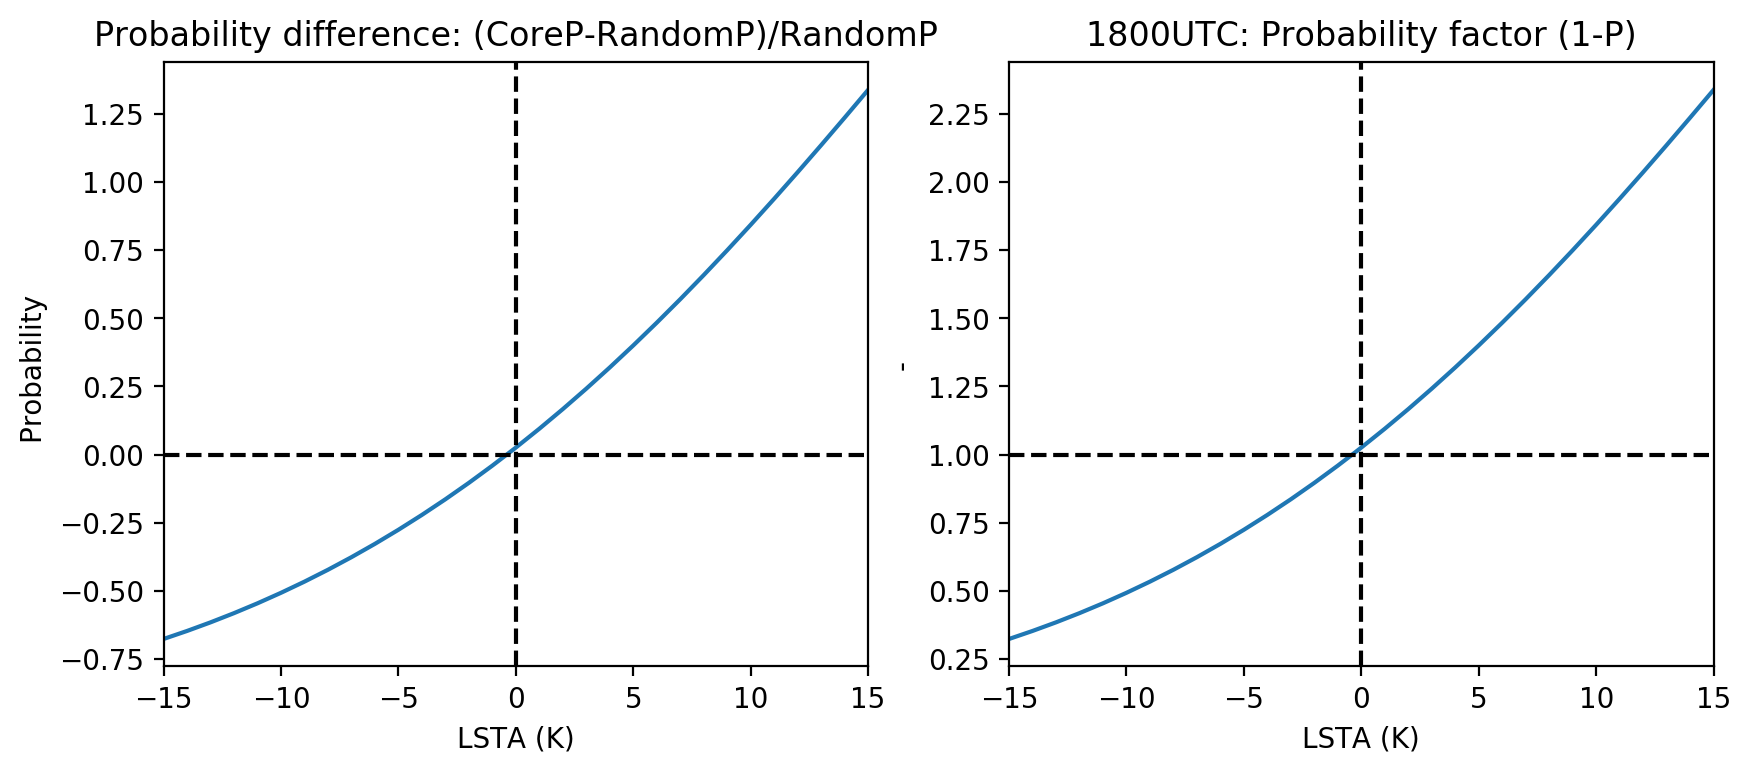

In [907]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(121)
plt.plot(bins,np.array(prob))
plt.ylabel('Probability ')
plt.axhline(0,color='k', linestyle='dashed')
plt.axvline(0,color='k', linestyle='dashed')
plt.xlim(-15,15)
plt.xlabel('LSTA (K)')
plt.title('Probability difference: (CoreP-RandomP)/RandomP')

ax = f.add_subplot(122)
plt.plot(bins,np.array(factor))
plt.ylabel('-')
plt.axhline(1,color='k', linestyle='dashed')
plt.axvline(0,color='k', linestyle='dashed')
plt.xlim(-15,15)
plt.xlabel('LSTA (K)')
plt.title(str(h).zfill(2)+'00UTC: Probability factor (1-P)')
f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/probability_plots/'+tag+'_p_change'+str(h).zfill(2)+'.png')

In [908]:
lpath = '/home/ck/DIR/cornkle/data/NFLICS/LSTA/netcdf/'
testlsta = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_200806191700.nc')  #19062008
testlsta1 = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_200806201700.nc')
testlsta2 = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_200806211700.nc')

In [909]:
sel_box = ((testlsta.lat>10) & (testlsta.lat<20) & (testlsta.lon>-17.2) & (testlsta.lon<-2))

In [910]:
data = testlsta['lsta'].values[350::,105:500]
data1 = testlsta1['lsta'].values[350::,105:500]
data2 = testlsta2['lsta'].values[350::,105:500]

In [911]:
data.shape

(364, 395)

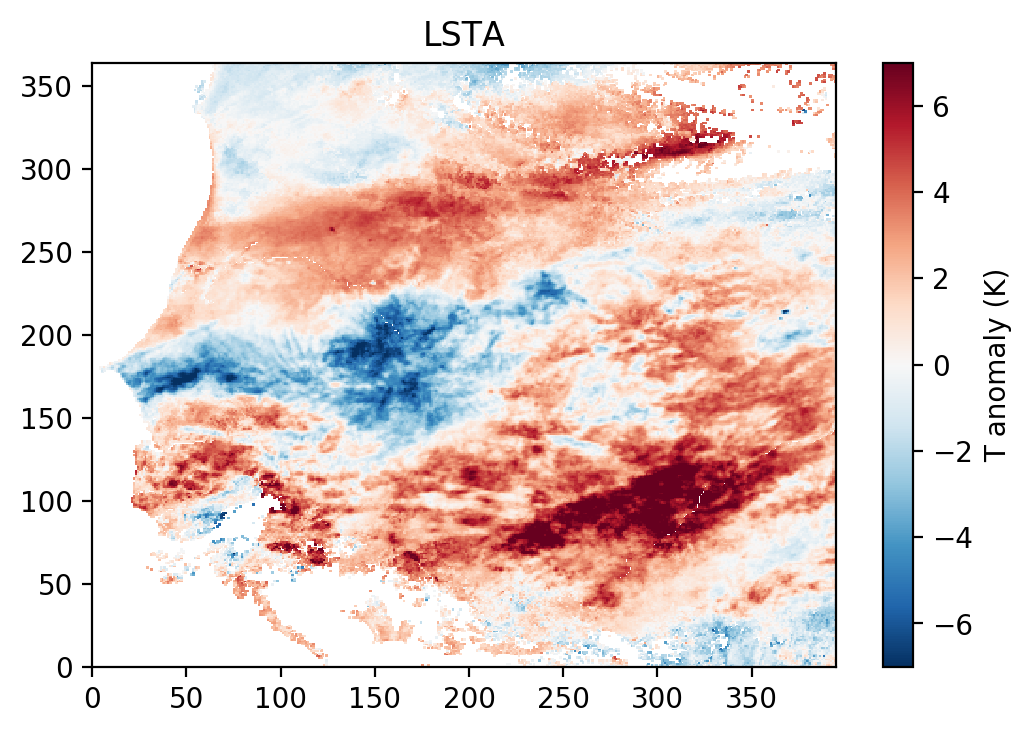

In [912]:
f=plt.figure(figsize=(6,4), dpi=200)
plt.pcolormesh(data, cmap='RdBu_r', vmin=-7, vmax=7)
plt.title('LSTA')
cbar = plt.colorbar()
cbar.set_label('T anomaly (K)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/probability_plots/example_day_map.png')

In [913]:
probability_map = np.zeros_like(data)*np.nan

In [914]:
for i in range(probability_map.shape[0]):
    for j in range(probability_map.shape[1]):
        p, fac = calc_prob(data[i,j], mupoint, muall, sigmapoint, sigmaall)
        probability_map[i,j] = fac
        

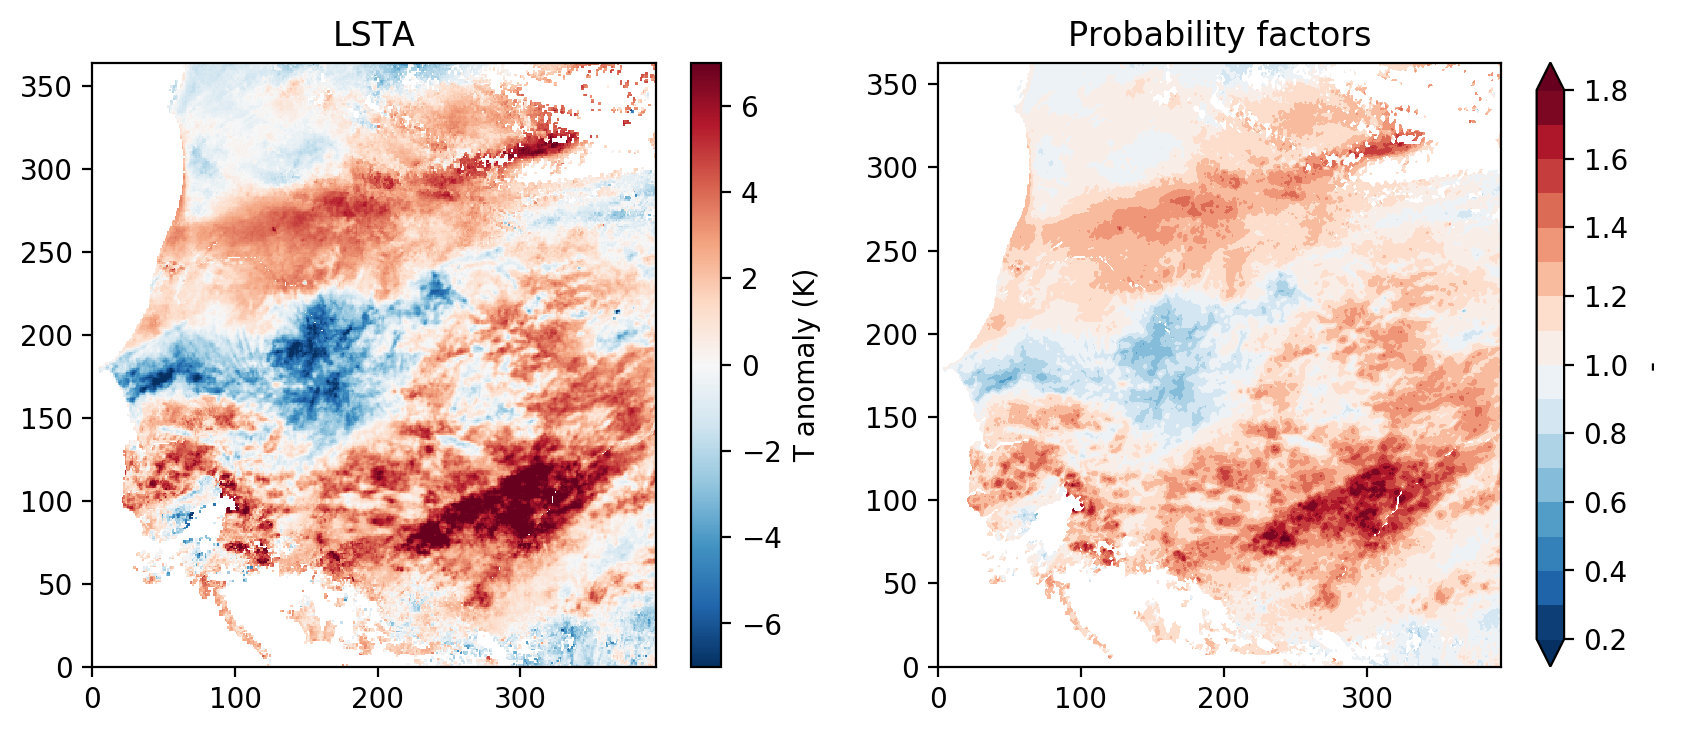

In [915]:
f=plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(121)
plt.pcolormesh(data, cmap='RdBu_r', vmin=-7, vmax=7)
plt.title('LSTA')
cbar = plt.colorbar()
cbar.set_label('T anomaly (K)')

ax = f.add_subplot(122)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(0.2,1.8,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
plt.title('Probability factors')
cbar = plt.colorbar()
cbar.set_label('-')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/probability_plots/example_day_map_probability.png')

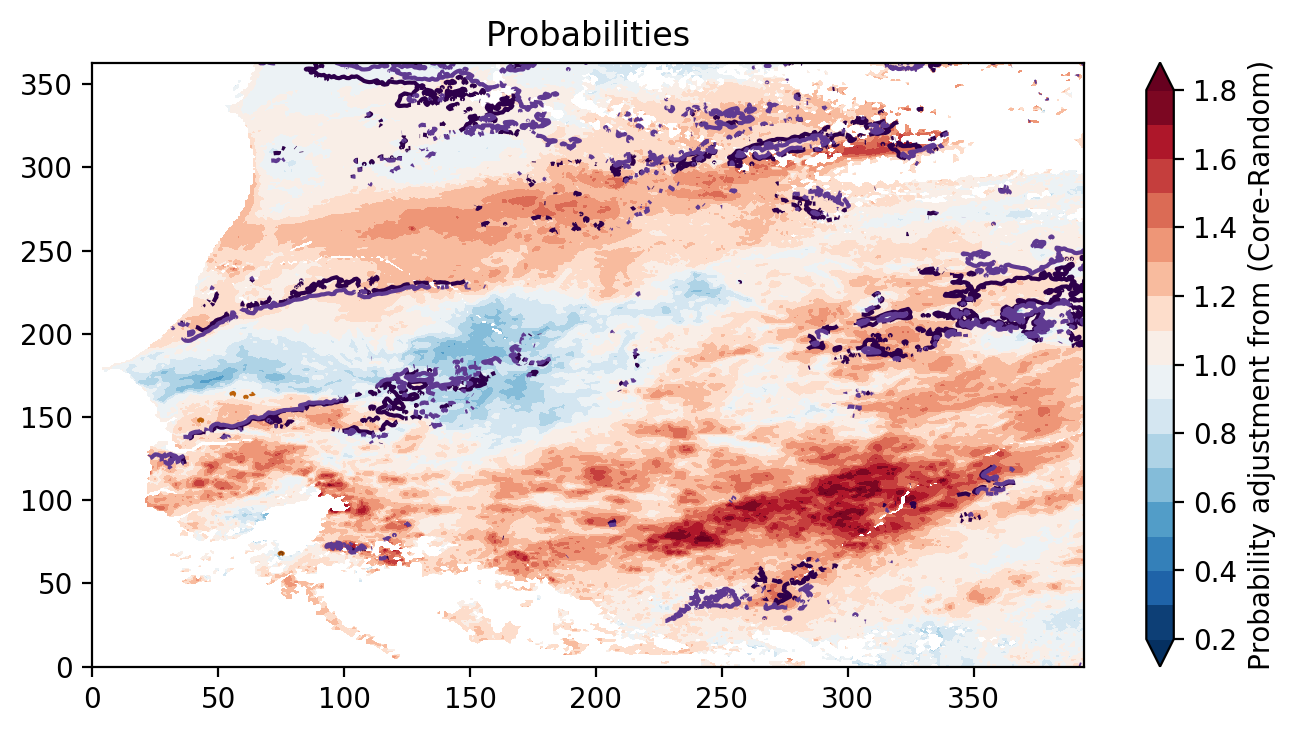

In [916]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(0.2,1.8,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
cbar = plt.colorbar()
plt.contour(data2-data, cmap='PuOr_r', levels=[-8,-6,6,8], extend='both')

plt.title('Probabilities')

cbar.set_label('Probability adjustment from (Core-Random)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map_probability.png')

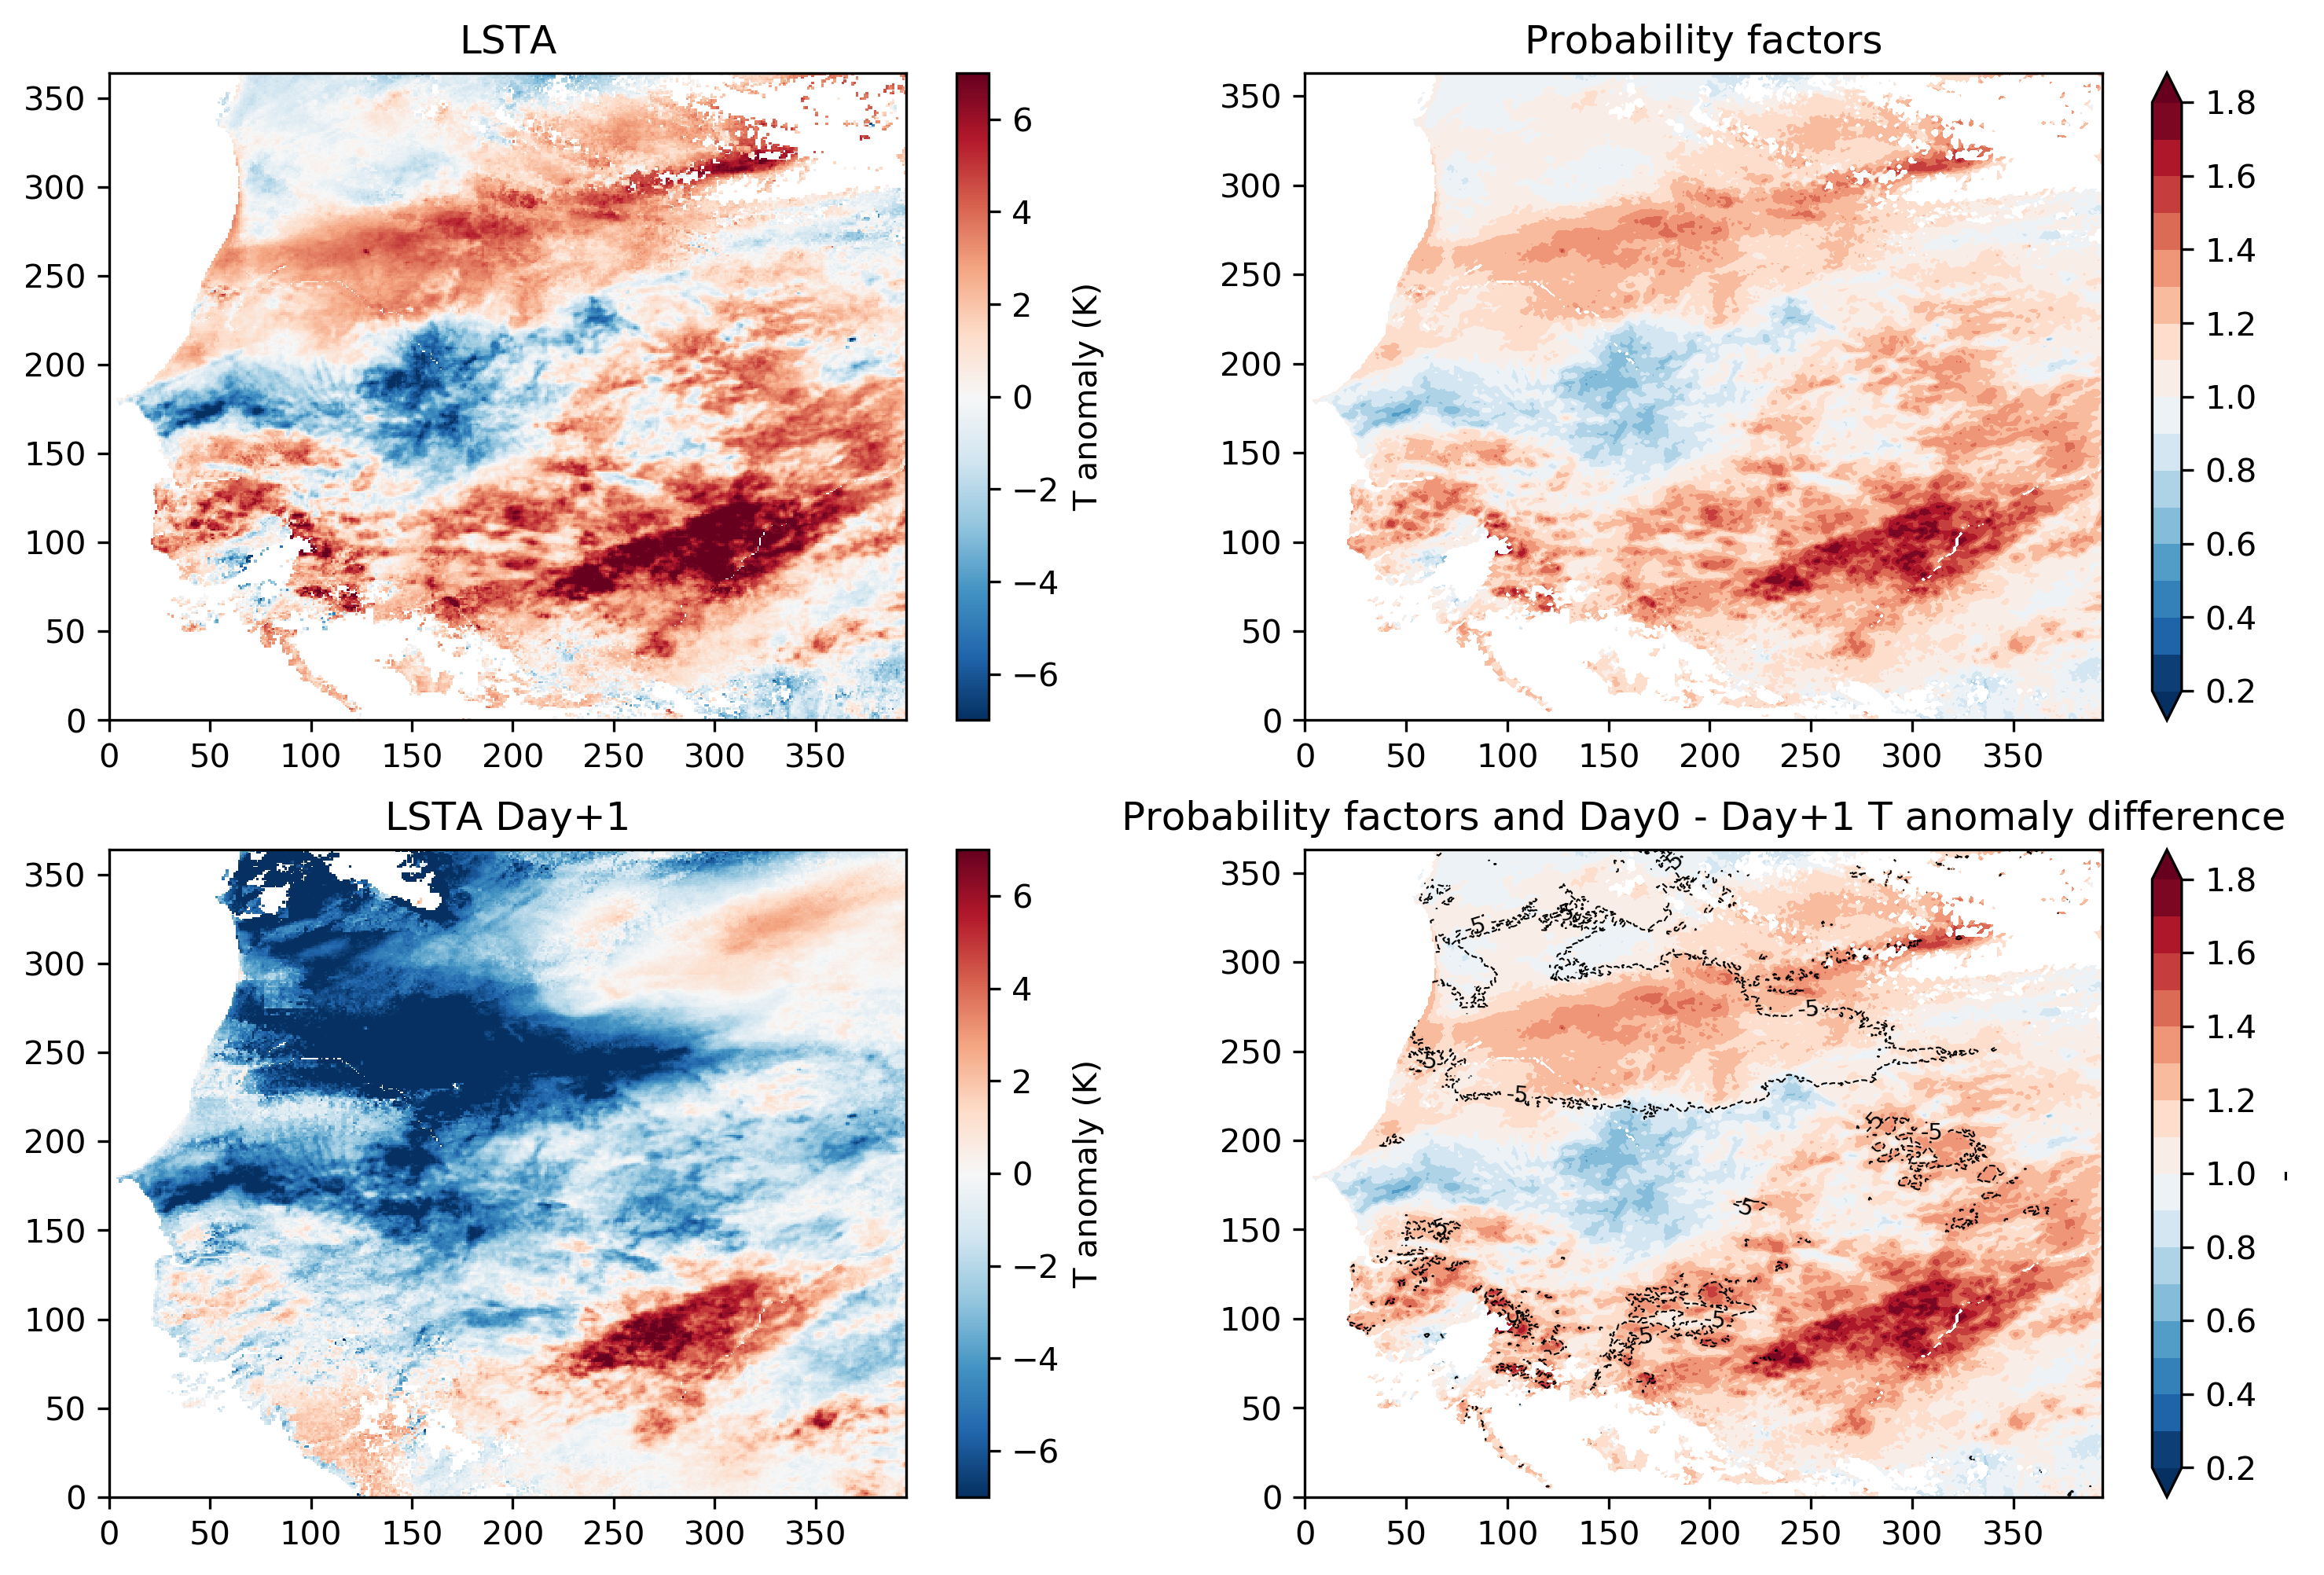

In [919]:
f=plt.figure(figsize=(12,8), dpi=300)
ax = f.add_subplot(221)
plt.pcolormesh(data, cmap='RdBu_r', vmin=-7, vmax=7)
plt.title('LSTA')
cbar = plt.colorbar()
cbar.set_label('T anomaly (K)')

ax = f.add_subplot(222)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(0.2,1.8,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
plt.title('Probability factors')
cbar = plt.colorbar()

ax = f.add_subplot(223)
plt.pcolormesh(data1, cmap='RdBu_r', vmin=-7, vmax=7)
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
cbar = plt.colorbar()
cbar.set_label('T anomaly (K)')
plt.title('LSTA Day+1')
#plt.contour(data1-data, cmap='PuOr_r', levels=[-8,-4,-2,2,4,8], extend='both')

ax = f.add_subplot(224)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(0.2,1.8,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
cbar = plt.colorbar()
c = plt.contour(data1-data, colors='k', levels=[-5, 5], extend='both', linewidths=0.5)
plt.clabel(c, inline=True, fontsize=7, fmt='%1.0f')
plt.title('Probability factors and Day0 - Day+1 T anomaly difference')

cbar.set_label('-')
f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/probability_plots/example_day_map_probability_all_wet.png')

In [ ]:
def normcdf(x, mu, sigma):
    t = x-mu;
    y = 0.5*erfcc(-t/(sigma*sqrt(2.0)));
    if y>1.0:
        y = 1.0;
    return y

def normpdf(x, mu, sigma):
    u = (x-mu)/abs(sigma)
    y = (1/(sqrt(2*pi)*abs(sigma)))*exp(-u*u/2)
    return y

def normdist(x, mu, sigma, f):
    if f:
        y = normcdf(x,mu,sigma)
    else:
        y = normpdf(x,mu,sigma)
    return y